In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import shapiro

In [39]:
price_demand_df = pd.read_csv('price_demand_data.csv')
price_demand_df

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002
...,...,...
94,1.13,321
95,0.78,970
96,1.04,387
97,1.02,831


#### Q1
Linear Regression on Price and Demand

In [40]:
lr = LinearRegression()
lr.fit(price_demand_df[['price']],price_demand_df.demand.values)
r2_score(price_demand_df.demand.values,lr.predict(price_demand_df[['price']]))

0.6214724117783329

#### Q2
Generate Demand data using residuals and p=1

In [41]:
resid = price_demand_df.demand.values - lr.predict(price_demand_df[['price']])

In [42]:
# Test for normality
shapiro(resid)

ShapiroResult(statistic=0.9835943579673767, pvalue=0.25649407505989075)

In [118]:
#port_return = np.random.normal(size = 99, loc = np.mean(resid), scale = np.std(resid))
demand_data = resid + (lr.intercept_ + [1]*lr.coef_)
demand_data[:5]

array([357.5116295 , 585.64624991, 478.34563336, 455.06325184,
       679.87499749])

#### Q3

#### Costs

In [48]:
#Rushed print cost
g = 0.75
c = .5
t = 0.15

#### Objective Function
Maximize (pD - qc - g(D-q) - t(q-d)) for given q based on last 100 days of demand and price data

#### Constraints
We create a new variable (h) which denotes the total profit for that day such that<br>
h <= pD - cq - t(q-D)<br>
h <= pD - cq - tq + tD<br>
(c+t)q + h <= pD+tD<br>

h <= pD - cq - g(D-q)<br>
h <= pD - cq - gD + gq<br>
(c-g)q + h <= pD - gD <br>

h >= -inf<br>
q >= 0<br>


#### Coding NewsVendor Problem

In [49]:
nd = price_demand_df.shape[0] # number of days of demand data
nd

99

In [50]:
# decision variables are (q, h1, h2, ..., h25)
obj = np.zeros(nd+1)
obj[1:] = 1.0/nd
lb = np.zeros(nd+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

In [51]:
A = np.zeros((2*nd,nd+1))
for r in range(nd):
    A[2*r,[0,r+1]] = [c+t,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = (1+t)*demand_data[r]
    A[2*r+1,[0,r+1]] = [c-g,1]
    rhs[2*r+1] = (1-g)*demand_data[r]

In [120]:
for r in range(1):
    print(A[r],direction[r],rhs[r])

[-9.44524325e+02 -2.50000000e-01  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [53]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

In [54]:
spMod_x.x[0]

471.8653795908935

In [56]:
spMod.objval

231.4836666471413

#### Q4 - Price impacts Demand

#### Solving it using QP

In [99]:
lr = LinearRegression()
lr.fit(price_demand_df[['price']],price_demand_df.demand.values)

LinearRegression()

In [100]:
# obj func would be (p,q,h1,h2....h99)
Q = np.zeros((2+nd,2+nd))
Q[0,0] = lr.coef_
#Q

linear_obj = np.zeros(2+nd)
linear_obj[0] = lr.intercept_+np.mean(resid)
linear_obj[2:] = 1.0/nd
#linear_obj

lb = np.zeros(nd+2)
lb[2:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

ub = np.zeros(nd+2)
ub[0:2] = np.inf

A.shape

A = np.zeros((2*nd,nd+2))
rhs = np.zeros(2*nd)
direction = ['<']*(2*nd)
for r in range(nd):
    A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = -g*(lr.intercept_+resid[r])
    A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
    rhs[2*r+1] = (t)*(lr.intercept_+resid[r])

<ipython-input-100-ada8a0c23341>:23: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-100-ada8a0c23341>:25: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]


In [101]:
#solving the optimization problem 
miqp_mod = gp.Model()
miqp_mod_x = miqp_mod.addMVar(nd+2, lb = lb)
miqp_mod_con = miqp_mod.addMConstrs(A, miqp_mod_x, direction, rhs)
miqp_mod.setMObjective(Q,linear_obj,0,sense=gp.GRB.MAXIMIZE)
miqp_mod.Params.OutputFlag = 0 
miqp_mod.optimize()

print(miqp_mod.ObjVal)

print(miqp_mod_x.x[0])

print(miqp_mod_x.x[1])

234.4249348783187
0.9536264966232614
535.2910012788706


##### Solving it using NLP

In [78]:
# decision variables are (q, h1, h2, ..., h25)
obj = np.zeros(nd+1)
obj[1:] = 1.0/nd
lb = np.zeros(nd+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))

In [79]:
A = np.zeros((2*nd,nd+1))
for r in range(nd):
    A[2*r,[0,r+1]] = [c+t,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = (price_demand_df.iloc[r,0]+t)*price_demand_df.iloc[r,1]
    A[2*r+1,[0,r+1]] = [c-g,1]
    rhs[2*r+1] = (price_demand_df.iloc[r,0]-g)*price_demand_df.iloc[r,1]

In [121]:
for r in range(1):
    print(A[r],direction[r],rhs[r])

[-9.44524325e+02 -2.50000000e-01  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [81]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()


In [82]:
spMod_x.x[0]

357.99999999999994

In [85]:
spMod.objval

183.96808080808086

#### Bootstrapping

In [102]:
def bootstrap_df(df):
    price = []
    demand = []
    for i in range(len(price_demand_df)):
        p,d = price_demand_df.iloc[np.random.choice(price_demand_df.index),:]
        price.append(p)
        demand.append(d)
    
    return price,demand

In [103]:
price,demand = bootstrap_df(price_demand_df)

lr = LinearRegression()
lr.fit(np.array(price).reshape(-1,1),demand)

# obj func would be (p,q,h1,h2....h99)
Q = np.zeros((2+nd,2+nd))
Q[0,0] = lr.coef_
#Q

linear_obj = np.zeros(2+nd)
linear_obj[0] = lr.intercept_+np.mean(resid)
linear_obj[2:] = 1.0/nd
#linear_obj

lb = np.zeros(nd+2)
lb[2:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

ub = np.zeros(nd+2)
ub[0:2] = np.inf

A.shape

A = np.zeros((2*nd,nd+2))
rhs = np.zeros(2*nd)
direction = ['<']*(2*nd)
for r in range(nd):
    A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
    rhs[2*r] = -g*(lr.intercept_+resid[r])
    A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
    rhs[2*r+1] = (t)*(lr.intercept_+resid[r])

#solving the optimization problem 
miqp_mod = gp.Model()
miqp_mod_x = miqp_mod.addMVar(nd+2, lb = lb)
miqp_mod_con = miqp_mod.addMConstrs(A, miqp_mod_x, direction, rhs)
miqp_mod.setMObjective(Q,linear_obj,0,sense=gp.GRB.MAXIMIZE)
miqp_mod.Params.OutputFlag = 0 
miqp_mod.optimize()

print(miqp_mod.ObjVal)

print(miqp_mod_x.x[0])

print(miqp_mod_x.x[1])

In [107]:
nsim = 1000
optimal_price = []
optimal_quantity = []
for sim in range(nsim):
    price,demand = bootstrap_df(price_demand_df)

    lr = LinearRegression()
    lr.fit(np.array(price).reshape(-1,1),demand)

    # obj func would be (p,q,h1,h2....h99)
    Q = np.zeros((2+nd,2+nd))
    Q[0,0] = lr.coef_
    #Q

    linear_obj = np.zeros(2+nd)
    linear_obj[0] = lr.intercept_+np.mean(resid)
    linear_obj[2:] = 1.0/nd
    #linear_obj

    lb = np.zeros(nd+2)
    lb[2:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

    ub = np.zeros(nd+2)
    ub[0:2] = np.inf

    A.shape

    A = np.zeros((2*nd,nd+2))
    rhs = np.zeros(2*nd)
    direction = ['<']*(2*nd)
    for r in range(nd):
        A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
        rhs[2*r] = -g*(lr.intercept_+resid[r])
        A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
        rhs[2*r+1] = (t)*(lr.intercept_+resid[r])

    #solving the optimization problem 
    miqp_mod = gp.Model()
    miqp_mod_x = miqp_mod.addMVar(nd+2, lb = lb)
    miqp_mod_con = miqp_mod.addMConstrs(A, miqp_mod_x, direction, rhs)
    miqp_mod.setMObjective(Q,linear_obj,0,sense=gp.GRB.MAXIMIZE)
    miqp_mod.Params.OutputFlag = 0 
    miqp_mod.optimize()

    print(miqp_mod.ObjVal)

    print(miqp_mod_x.x[0])

    print(miqp_mod_x.x[1])
    
    optimal_price.append(miqp_mod_x.x[0])
    optimal_quantity.append(miqp_mod_x.x[1])
   

<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

217.6899847565437
0.9584297232257944
492.28545810638883
239.79993400900617
0.9636974316718212
533.4076243980875
223.22790163209106
0.9449774524127578
522.1871899041863
236.31251607893614
0.972846581897769
514.0639288342767


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.8042967051408
0.9264517370623173
554.6118653108311
228.43088807750564
0.9356178914354117
547.1799629019802
240.20995962912912
0.9239116275305652
592.4280040954508
214.5323568642002
0.968379362131522
473.2777907536654


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

255.57010002455195
0.94031944387138
602.0635895936666
231.00242958807485
0.9644146416091225
513.509189777595
227.35598573837524
0.9501498327666525
524.3792574790508
230.78700488433446
0.9481175290918538
534.8000635760663


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

238.20777480867946
0.9384045567760589
565.461761321147
234.89319147117135
0.9301313856428075
570.2694860695182
215.07254480291817
0.9512404562877705
495.6846114901247
230.643713521883
0.9796254519842323
493.77575626487055


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

240.13660209880004
0.9463197095903795
558.2454476188834
249.83581109266152
0.9692548424413929
547.4689714637069
243.30616537934043
0.9984850983056845
497.27497886929405
245.75422492825328
0.9805177182215421
524.1470978032737


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

223.9465562689395
0.9486566685363588
518.8085887262395
233.67462897879545
0.9320476644013245
564.5420877444183
252.60079489004602
0.94702796306857
585.108449518766
237.3411384363951
0.9448683062720808
554.0607206557137


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

237.07053389556722
0.9341155223195097
569.2699894157845
241.8371091802278
0.9782864428554419
518.7996043333301
222.72852992277853
0.9672443973144115
492.1757329439152
245.20650093200652
0.9575814418138404
553.4905982620709


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.13819411577106
0.94080792931807
545.8767726340793
237.64850466871053
0.9377279006332435
565.1898191430638
234.9073482151607
0.9613547321887362
525.9437019472119


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

238.2251744015798
0.9484295691298344
550.9558303602136
237.54611183692214
0.934335347895049
570.0337356372512
235.57401900089076
0.9700409756195466
516.0693544106871
240.5325062039551
0.9443951461454388
561.9226691533345


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

242.10588793820534
0.9577489863597107
546.4832369034227
236.06515819491278
0.92770139987444
576.7333429281064
231.48663271065448
0.9450990334281261
540.5761110817717
228.37103234214965
0.9677027093428437
503.67430098735633


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

256.31016237356107
0.9417660849629658
601.4884571326768
222.56497388902994
0.954956037250194
507.40953317044773
235.5057547417373
0.9448938522813716
549.8985752954021
246.36335819305918
0.9542451942209215
560.727846514075


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

228.68253670951663
0.9434346223070598
536.6011238747393
238.79035500956502
0.9510319610280392
548.5387316774211
231.78075094009887
0.9523425149445047
531.2065690257932
243.0049313463005
0.9316024282589197
586.8301069273336


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.84745973659415
0.95718966984697
535.7543167372704
221.287398921849
0.9622789627892059
495.2593477798818
239.54566382281018
0.9616986426946894
535.5347157840525
238.62245887053564
0.9534033127933703
544.8542193972169


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

222.73293817440663
0.9558500932456466
506.6158359002883
236.02380158699953
0.9426016629051487
554.3578325440118
243.03836508805398
0.9624297390019088
542.1063795180054
239.7990298892994
0.9597927478837521
538.6585276040075


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

228.60122237121163
0.9429075532038089
537.1574160964784
235.32437627062973
0.9689141880213539
516.9816582564067
231.328597887858
0.9558835410093178
525.4273495403323
229.03194993500142
0.953721829898765
523.2745377803128


<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

246.0568551864269
0.934849964721188
588.830057105348
237.09026716299059
0.9406308992157868
559.638362930532
239.72583255454833
0.9538352583007489
546.6858346734286
228.41950899268363
0.937287817978778
544.7392218957274


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.62850386857235
0.9557555924648113
526.256800991677
211.63907717114216
0.9793003014064042
454.5176897976052
229.7619768921695
0.9497437008522763
530.279363382743
235.2801154957881
0.9530447395953106
537.9753288880606


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

226.4118940679184
0.957466219906201
512.5673180273415
221.52081918728868
0.9583386319972549
500.75833399365223
244.91800112184978
0.9581389314817027
552.083755617829
230.0607412500508
0.9646427936118338
511.188548214509


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.27880134663678
0.9486901491293737
526.190129404604
228.67853191178665
0.9527144023078328
523.8477800421031
230.7648206803317
0.9707250452796023
504.9790856172204
232.65409257616216
0.9464884221087043
541.2437598980302


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.28073301891527
0.9678979626774127
516.0589090637797
235.83693049830117
0.9412037665233589
555.9604483599047
228.54344181179636
0.9701210579218206
501.0121188365649
236.36773410559226
0.9456136760698626
550.8071289342638


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.46394108629283
0.9466904044917913
549.4895833843351
244.6666580285878
0.9686907380577048
537.2014422825258
232.3767352198579
0.9862390593117875
489.4657378059999
237.98724012933758
0.9409004904455076
561.2785208930756


<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.81788011569802
0.9303241455165229
574.4485495770812
226.1692781561469
0.9424476733472136
532.3076622546253
248.1986186389538
0.9387358060967673
587.7424421367615
246.26909534696733
0.9406384682749781
580.4580336285112


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

238.36473885911823
0.9392930215468596
564.5032384223503
234.39208291054206
0.9892504255762655
490.0482623532633
220.53454838762377
0.9456135426776521
515.2761158484635
220.94257676236884
0.9875366223773299
464.48352187387724


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.24891754798477
0.9577514169547385
529.3156090013385
232.58107257521647
0.9839596470139551
492.5943073903002
239.79085720959938
0.9479008906712699
555.2022446965625
230.21376912406527
0.96599578608247
509.7855361421029


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.2464161692435
0.9631593411119354
519.9766442728835
236.05299500433034
0.9483204917996542
546.265445068172
241.07631219116934
0.9460578146421783
560.7298999821578
237.4584024237438
0.955927486205449
538.81319614481


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.77034424377962
0.963699831573415
518.244636952206
232.90051833924667
0.9661238843959555
515.3860569268393
245.4001136509246
0.9550514306316453
557.4667504985318
242.44826215821604
0.9235757788138274
598.2495427188942


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

221.19526147387
0.9582341570278896
500.1814547377447
240.2225529332502
0.9656130014064859
531.7705321524109
240.38097623601743
0.9352899503588992
575.1095116074439
233.07123663377638
0.958017233694474
526.3877422852279


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

226.38255123603585
0.9706400809746921
495.77432272049384
238.4604655332787
0.9467292559926868
553.9035950132475
236.81087493202358
0.9440009435363272
554.1151235544245
235.52079702815968
0.9465213992325582
547.6175823696158


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.3808095070474
0.9394583746181803
557.4687842207745
233.09017828052606
0.9561819149607584
528.8895716345772
235.36310601625723
0.9354888157058104
563.2856237389399
243.53638699368094
0.9641875070018342
540.8040266438063


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

238.76598986534304
0.9613780563558328
534.2761074537884
227.38370909157447
0.95112377124054
523.1248111604131
219.3836122123339
0.9553939429932865
499.85379651428053
238.70496436568806
0.9588377504925077
537.5724357365942


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

251.1184130356662
0.9390172754109385
593.9617842560839
239.3905152194252
0.9518032776909776
548.785285065892
237.262645660835
0.9508813651935251
545.3621088149985
231.36540804304536
0.9627201448594901
516.4859012003689


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.80864293785385
0.952488141463033
548.7498710678271
235.41430304112214
0.9589671354006665
530.227179556188
238.80218454604892
0.9544677428171753
543.7741483033977
239.20220289167764
0.9398905580361544
565.5245803710073


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

248.02993237510077
0.9456083999777033
576.9860643390925
240.19585804050348
0.9660186911897134
531.1762004504629
236.10657010902628
0.948335066359385
546.3644171468471
228.959816552579
0.9627662457848541
511.2276869753194


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

242.0141803440781
0.9506009804242699
556.2993192280919
233.85423471239733
0.9623360557963722
522.3688476851436
244.7416638679931
0.9464624512424534
568.3543019948033
238.91215197632914
0.9748514802188459
517.008627377985


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

241.33216197953084
0.9688424043153419
529.8879319039565
229.83124528547728
0.9719511663488066
501.467848597551
237.74615131917767
0.9402767155332354
561.6467680766953
220.74988274689804
0.9682661745267318
486.6905315576001


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

241.13662291676314
0.9519616268758224
552.4265813323806
234.3976884992028
0.9298419899947574
569.55799108008
235.6035792642367
0.9753399600892323
509.42939721824786
233.35997154860797
0.9333318934560768
561.8905460204192


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

223.0963719900053
0.9825815233123333
474.5900680962152
240.3495589287063
0.9419859268365816
565.0358176555422
233.0937550296037
0.9431260310669219
546.9888711049364
226.59246309815944
0.9696943057029346
497.3909611866808


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

230.96477575012523
0.9596080951515114
519.687868502999
243.89912795594387
0.9715964562193593
531.7394040860265
227.26876142707238
0.9467351344591121
528.8429737570084
226.35793007602615
0.9691961927190039
497.50953211002616


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.29990178005664
0.9673453786259117
501.83255975069955
239.2715560485758
0.9566703919914546
541.7685296926367
238.95461052840824
0.9484861961791985
552.5019558135701
229.1135205447065
0.9718067151579667
500.12622168580276


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.07938435851884
0.948235664063176
526.3650893383698
242.7777388089096
0.9531052853702122
554.4392688802884
240.22311046285995
0.9504989022809062
552.4689147965555
241.54100477753377
0.9412823024360061
568.7724865417005


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.15698365746016
0.9645411785472211
500.7628362117837
234.24462144369
0.9665875698596308
517.6699564390764
249.589409192537
0.9611950037354458
557.9901639958834
235.20197379856586
0.9492841381852165
543.0170055163713


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.90039046776997
0.9429769853490403
530.9628746329995
226.9266491214073
0.9479946951967827
526.3530766465317
244.38019279430387
0.9504426747163855
561.7773881474823
239.70536668481554
0.9439095928454805
560.767126925741


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

250.23462949311238
0.958317067025207
563.436409263368
234.6220952823369
0.9473503246422142
544.4361600711146
237.01281108406033
0.9727584864222117
515.6568826251628
246.82044057462144
0.969853962932212
540.2446430652127


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.56728885772532
0.9577096162834506
527.8825081214258
225.14513011486815
0.9495138783988245
520.3232551843583
239.42535519880744
0.9457029044098866
557.5400368201202
228.89894607080305
0.9373048386741901
545.8110511434103


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

241.44605312620524
0.9345707316131194
578.6531013440328
233.93007688142302
0.9461325108004149
544.6035716326667
242.17851346334464
0.9349359716286108
579.7797422503348
236.53782830449654
0.9700346018722795
518.1280140881827


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

220.9765658394083
0.9940251316439211
457.33359028700204
246.93873507908347
0.9322543310582206
594.9173475708983
233.58863864442264
0.963176462831074
520.693135443801
237.8707888876727
0.933302181972682
572.3452399408126


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

229.4157466315903
0.9507032850139419
528.2008859868264
226.845282264017
0.9425337045453939
533.7152034549003
231.91141193577096
0.9408727056367258
547.5378935756936
238.5590886081843
0.960122633295663
535.5164887488185


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

229.29713615648689
0.9616825587029689
513.358140209499
238.76262380298635
0.9368268369438786
569.0817673014611
233.97760474380516
0.9486413415391722
541.1879450524078
245.76664353465048
0.9716700332953757
535.6025442416772


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

240.3203454555735
0.9683083647795317
528.4287059596165
223.915918681957
0.9648790472055081
497.6673577862164
214.99664617792314
0.9571480113851967
488.0127806999844
247.78075626553323
0.9392003671657265
586.0792896193437


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

243.7807916456477
0.9649536827576916
540.2982166711541
236.41108055871155
0.9329334991979374
569.533480161037
234.72386630813344
0.9695612785062885
514.8730156320993
245.08507666656055
0.9519404838191042
561.1930793770713


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

242.4556803564251
0.9604896164123999
543.4837083916406
223.20643364488456
0.9499843035028898
515.3819233510569
231.4030625962323
0.9643466573433155
514.4596241436635
241.22240811241113
0.9579888433251172
544.2234023236525


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

241.00865971849794
0.9483904172672508
557.2190990029263
234.635264527544
0.9448024573467565
548.0720320211975
244.08482509431883
0.926668159120189
597.1321958910361
231.01745308446834
0.9566472766530159
523.7248175972319
224.77995978187846
0.9896460514553307
469.95276221883995
229.92919933948315
0.960939427957023
515.694290726448
230.84892526117642
0.9495706207240444
532.9340412246876


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.30367306673088
0.9676103453155913
518.6162847478125
238.0959389152565
0.9853725585226769
502.274660751758
232.154733331113
0.9779268007567634
498.9949514230563
214.58094574950655
0.9752512596097612
465.30559000592297


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

226.40372219825963
0.9500705793222699
522.3707791562491
231.37880582979392
0.9522446667549282
530.451144421301
228.2177790569824
0.9585226395020188
515.1287126492366
241.63626266840652
0.9510125103119079
554.8761016086502


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.25412048155204
0.962327766959793
516.7557891427028
227.94843705382345
0.9708693230096802
498.81702650102835
234.69450885362676
0.9529872187047137
536.7616864469921
229.38861001992564
0.9418038019163244

<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]


540.4943019098495
220.573703789177
0.9466709534274366
513.942403253154
216.38974604080408
0.9815759714412768
461.8323961281737
239.81550711754267
0.947965356056289
555.1651213439055


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

228.63808272180245
0.9403161524313481
540.9035459773157
239.90799222013152
0.9499281942168218
552.5773100017209
234.35812457333395
0.9436845533300088
549.0428341995431
232.10430782307049

<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]


0.9565333795750152
526.2573873295142
247.00156707893984
0.9257960253109052
605.3797466220672
235.6213184461085
0.9431767183697644
552.6198585289118
227.68033846178446
0.9539612076946914
519.9763426455836


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

229.14085555494785
0.9588990936165968
516.6477878423146
238.0323563873078
0.9551280461479663
541.1702617124466
232.61610153325955
0.9620966619912995
520.004192175728
229.9468303664496
0.9366843776933346
549.1071722174432


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

214.23988865906585
0.9806376355980758
458.4273071915905
229.69962338875257
0.9959733023526787
472.79052528058025
241.61496446582328
0.9527024751738025
552.4398390804519
249.5910532106309
0.9472891743599646
577.9881829879655


<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

238.59727051829714
0.9534477660522979
544.7369101551607
244.83907365535788
0.9240263411258538
603.1617424655427
245.6625583300147
0.9494442838934579
566.0676671427607
226.41740114283357
0.9871810900503727
476.122383344374


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.30523795326962
0.9406396270053939
553.305167915564
242.20283391221142
0.9521468165497562
554.5235559354611
246.01245266439014
0.9475823100242654
569.5584779611703
245.36291537816032
0.9610482511133378
549.0277336336229


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

220.08684752243107
0.9444170546665075
515.8852044369844
242.3943797071904
0.9590708237399008
545.2929828864415
226.48065565748675
0.9551994911124999
515.6947283634337
228.0531459281226
0.948751108018984
527.8326402052533


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

241.28867578946165
0.9344305079074497
578.5050964052439
239.97462370810945
0.9348671245339268
574.8170495510082
225.69337375335544
0.954683177753834
514.6455073020273
229.28319990185696
0.9568634453377115
519.6407295083031


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.4272755661384
0.9381670474269693
554.9042003506395
216.99870607507
0.9488935876671568
503.0121234584037
237.80629672516466
0.9569028532519441
538.2426353375181
240.94258799415184
0.9831530244008773
510.864972616202


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.76545718290345
0.9407387798913109
558.7435719760716
235.54472773532007
0.9656558809387854
521.6680532956118
231.96560195433244
0.9724170872207459
505.40725734273497
217.6227038547063
0.9592126385579057
491.15448779134977


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

241.25138564482995
0.9572651927083045
545.2827798020242
233.70450440189234
0.9558916876588107
530.627998079371
217.85612167437898
0.9683315758011061
480.4318030357804
246.3342041546091
0.9507268701762036
565.7047346509565


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.86739991571108
0.9291803983312897
571.661660759286
249.787595366676
0.9531451839644964
569.8522908833387
229.1688435084393
0.9638698332947401
510.25949525037123
242.58556616584906
0.9465230037014951
563.4370449986054
251.6918355314399
0.9579038842411671
567.2039826665323


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.572922230451
0.9570492117020156
526.5926601493725
229.0804044732265
0.9335131051854941
551.7482537188986
229.0749745280275
0.947252232556668
532.1715721453656
228.3715899904571
0.9447393274867819
534.0779938809536


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

238.04990891812236
0.9507496291243932
547.2929436137911
241.63902940229877
0.9511367066914584
554.7060403217369
246.87499955453245
0.9495759277429077
568.5738373699229
224.49071833706444
0.9561647718501818
510.0610072141284


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

238.7021735614926
0.9403275784313027
563.7432182075524
240.87451790533578
0.9515481514549043
552.4299318165596
233.19163265185193
0.9556380733740998
529.8451304808331
229.65358061691813
0.963908495362672
511.25477128265965


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.04494142884914
0.9470747644584877
527.8759164790905
243.34794843555824
0.9204253793073979
605.5103680023515
229.2322754794568
0.9649543456211608
509.0071485280973
219.61890352826367
0.9667633181230726
486.10865002705424


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

240.68579563493654
0.9543993676528197
548.0140655971552
227.8448545798576
0.9610165684957611
511.07256710414526
231.69587355578346
0.9400493598998656
548.2318475490983
220.98401580963605
0.9534169483949809
505.9341312034462


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.764989030303
0.956485487659794
529.9595032389775
232.267355440752
0.9594365418782329
522.7488784572752
230.90041563068735
0.9720232988425843
503.6432854777391
228.57098428771042
1.007561101171831
457.82913129351056


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.74155816573193
0.9613994025995343
527.6925395284036
245.47515775005627
0.9492859634168739
565.8800335330465
234.80085950061243
0.9633312231162436
523.1070932237168
225.69330650030588
0.9476189076172483
524.1110999167914


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

240.25114987511915
0.9554230667380011
545.636476365241
225.05222806401662
0.9405834955838267
532.3847902968711
230.9844138381618
0.966653520183898
510.59843493558054
239.01554114071337
0.9582609660915424
539.0339334578385


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

219.53155178532506
0.9775327987506675
473.0427416943224
234.77785539580873
0.9416718698370781
552.8831045702802
244.58023646057063
0.9370484640159126
582.0611502785042
227.6719916135296
0.9544258893239191
519.3392019291817


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.45122616838535
0.9554055359059881
537.3167140810339
211.22287543718244
0.9864286917271912
445.75362963408656
239.19296057422844
0.9729100179002199
520.0744463064419
237.3668467177206
0.9670701477403427
523.7318357005524


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

238.85117306237134
0.9455105373126592
556.5287213252984
240.05020606310518
0.9538625066798456
547.3625976741752
224.112453163993
0.9518613548891198
514.8924134257671
238.31469054266063
0.930682424210025
577.3752860363242


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

220.82528961078833
0.950532058655467
509.36663987987214
247.07242984731624
0.9331137883534526
593.8765468156597
232.36794399334826
0.9570509816013152
526.1418112292599
235.16157564475498
0.9421864099533601
553.0084633919906


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.06435761847388
0.9516443265097763
539.4297044687552
229.75745354813262
0.9622299741108877
513.6452064979694
230.58299297471058
0.9281478456132769
563.2388114471264
230.87123881179923
0.9640781408566681
513.660575152527


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.50597127022388
0.9479461718061343
545.571888109749
245.25392214346357
0.9507565695137088
563.265254560256
235.00789808626132
0.9532929030533875
537.033660108505
241.85745996307742
0.9317986196871931
583.867371134515


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

226.10561495250795
0.9445022263653219
529.3105087691667
241.25700413289883
0.9408864147143411
568.7154994579395
242.643222156114
0.969289411198282
532.0958298507372
240.2329727613071
0.9659732627160549
531.3159359549842


<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.77204731837423
0.9859665504418555
490.60140682601656
239.1535037637077
0.9650348659018664
530.2386211538427
239.30605907935023
0.9511493269842537
549.5169705709403
230.92237832540536
0.9410153359664944
545.0906485180794


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.53169210649753
0.9530553097012489
516.4437204440641
235.11268610336106
0.9653771750077322
521.1030906258363
234.39419574728913
0.9465466505814463
545.0588816081674
225.8146000822619
0.9308340502061567
548.1284218236841


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.44345326549296
0.9414523639241641
563.7690983126682
225.94337341862752
0.9694361115563851
496.3286575788766
243.51561041078162
0.9586789854467553
548.2760249805318
229.61562009958266
0.9597682497303035
516.5427742788597


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

226.21441404958637
0.9495456890531067
522.6589994217927
233.45685238349483
0.9533684669524786
533.5088019449136
217.832523125099
0.9825329246902791
463.7376555342703
241.65177963974406
0.9543488047748985
550.210602031569


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

226.17290784046668
0.9701282179797968
495.96087810820546
239.0614879431862
0.9455995525407591
556.8725201984864
232.58284064279906
0.9237417035116016
574.7002612911893
229.41773679018593
0.9420923496257732
540.1518429637578


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.69631518186293
0.9424247734582951
535.7911392394223
227.54339105797817
0.9263458617165514
558.8498058357068
244.91003301716978
0.9567564182290722
553.995061026773
250.2346775439721
0.9491857443413927
576.6211673899071


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.67021895639596
0.9475854568410195
539.7445199906647
219.0006113639554
0.9548479973512456
499.71391136821154
243.71772939723473
0.9614104065259833
544.9644359126911
232.89274998544602
0.9778560458312658
500.62587592326844


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.2966842622452
0.9541633419690695
534.2752303546239
235.51294964389626
0.9443007128701175
550.7625421887476
233.51167638520178
0.9615757517842028
522.6273812152546
235.69559432235474
0.9540798439389812
537.469888753148


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.9721061032992
0.9557475811099055
533.6040706107073
227.57229726388346
0.9537791225786104
519.9810617644489
229.44229476003875
0.9487205647143249
530.9701614522354
233.89940291826588
0.9481206955008499
541.7411289503227


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.2347512161939
0.9727258765106164
505.5908620683675
238.670323915562
0.9505391021692664
548.9655156025967
217.67112059716192
0.95982590742048
490.4911791591849
238.8775955027245
0.9354030167941181
571.4852080106033


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.86574160282976
0.9498696241537156
534.7834887472101
234.07632905000264
0.959885564739291
526.0888784480508
227.56811692667952
0.9545063051161364
519.0037074191171
241.4653704309669
0.9535570534149668
550.908710208826


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

218.40461890238316
0.9393693250813143
518.9613912056111
242.0015394693021
0.9525959008369729
553.4441005581959
242.41098408941457
0.9298139827649539
588.2442862320772
241.32388588449408
0.9567233686659231
546.1894078836635


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.1860598609187
0.9389177857011324
535.033232378405
239.79306076486023
0.972170267270179
522.2935772825886
241.16940184555529
0.9566255278576922
545.9863655440464
231.00220120594145
0.952219558114285
529.6525324007106


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

228.10363712206322
0.9555019654272358
518.85880893542
243.87113976164233
0.9619150939843757
544.6080922036376
228.58775725605324
0.9383946012984737
543.5327948403251
230.59416708497474
0.9561490607142562
523.4618771873685
234.90281241050297
0.9513894782369682
539.4244434049135


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.80717123815202
0.9632063144219672
521.1258746289726
243.15205035473673
0.9639406249246775
540.3087116484218
244.54470116736593
0.9534690451721738
557.8227578957315
227.34999335490943
0.9565867548116188
515.7731963275629


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.71751100459005
0.958508308244863
527.1422953361259
243.81157101805047
0.9941476948002347
503.4099318046039
240.20823763048634
0.9601221709368896
539.101267085924
223.37110080048797
0.9621649580387396
499.91111886897636


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

229.6050463879933
0.9527615728471113
525.8306945783171
238.7235678205077
0.9523486589318508
546.546573677552
219.89996306515422
0.9871927653649604
462.7313983215453
231.91925620347433
0.9340768209862802
557.4611319851205
224.27522667663084
0.9221617118801948
557.4910443646751
227.69480460292334
0.9485000001751135
527.3768561645913
244.88470273076473
0.9572097625701634
553.3059283267279


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.9237050343179
0.9594168515602125
530.7336076435596
228.10450926957924
0.9631850841371276
508.8418446070401
241.20736135026982
0.9874127616067336
506.199420471323
240.70661182058507
0.9896475029383622
502.4778869088386


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.656728356729
0.9506174287862652
524.4141739551442
239.9276034170016
0.9421555532327677
563.8320729027921
231.13430221089789
0.9447872987155745
540.2225189951645
232.15702686557734
0.967965674998089
511.43377994869235


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.6412944012843
0.9529568042905578
534.4782464435659
235.30436948555007
0.9691824008533674
516.5948077618426
228.36149929453472
0.9625315338504986
510.23674440782753
224.36868215267532
0.9794037621216544
480.95421815012884


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

246.22462295071887
0.9712962890433794
537.0665452259532
235.62741610758826
0.9437594215787392
551.7961535545188
240.38402950870295
0.9736379266117774
521.6590507922729


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.042824728695
0.963397029213615
506.2790870618316
232.71984857257553
0.9592000708144724
524.0473128793969
226.6662499046231
0.952617555349031
519.5322084398354
234.90451405509043
0.9658864779490097
519.993521499339


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

229.51194373471822
0.9779294758372953
493.46201773192024
234.95203901553873
0.9501674131384941
541.2292932265802
234.49511204141413
0.9703616994939834
513.3656572033165
228.1945728208359
0.9321245631885673
551.7448146322637


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

248.17193179154833
0.9565126966778884
561.481534741957
240.26697868849556
0.9616013790178726
537.2281334417509
235.7620887500741
0.9667203738101139
520.749770172794
238.33348224535257
0.957526130924399
538.5456678967411


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

230.35983136696177
0.9554266871970051
523.9126674177858
227.4163388285683
0.9604688160604755
510.85118552055184
248.0228018437051
0.944277322123853
578.953777472612
243.2158934891745
0.9681118064505793
534.8719420848156


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.13982849539434
0.9531881288999295
537.468618743316
231.098049780667
0.9851789697896912
488.0857266612381
214.31402942493924
0.9442862921678168
503.0686470877261
237.56173405577078
0.9630246418107574
529.4725244602114


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

228.08140064279064
0.9618146311969996
510.55446377024015
228.20285975848014
0.9705438901302906
499.7615959473798
241.8228123202232
0.965117183524284
535.8687140160444
239.0212712539319
0.9535474702293927
545.5332987581456


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

222.95494266489868
0.9600717053417612
501.6684524752677
229.335566285783
0.9610963888075956
514.20232555975
233.4744882274183
0.9511965496605139
536.5258664482035
236.1076718725435
0.9592218902638567
531.3956803638026


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

237.87749995195873
0.9706710690121769
520.1585443457612
242.77412996090743
0.936353840313211
578.9841681047619
227.3575866071285
0.9776703208580989
489.26579775969634
234.2735127694673
0.9761804719747218
505.58671793077195


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.67348625340014
0.9309137932675835
561.6076552961118
236.87936126038585
0.9524972723430849
542.2634900597888
227.40464816086023
0.9600924693917523
511.31328400110294
229.8908496369986
0.9711357831654321
502.60958790155416


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.57433532582377
0.9572886252955417
515.3414772234757
247.1731752695773
0.9568207383836215
558.859186698426
229.40998163445784
0.9685579850010962
504.81685127742736
233.2140926804857
0.9445103227368674
545.2910194467726


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

228.734738504608
0.9470049134820404
531.7519738822454
242.7818351787605
0.9378190483283264
576.7792062188241
230.1915989898041
0.9601642908427207
517.2766159167572
243.71292452753733
0.9545184476347726
554.508254568074


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

243.02058188102114
0.947595888222532
562.8543046750096
241.00596446057875
0.9616824076329709
538.7195399682113
216.44472004314025
0.9641794482902055
482.4502553867048
211.61247908236555
0.9859411531821409
447.08801873326115


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

230.60002560842463
0.9554891090845646
524.3565332358387
236.28304563938627
0.9771723914455137
508.57008393850367
224.68650207021005
0.9481885180484382
521.0904065210896
251.11814206344047
0.9421731270016982
589.1143293713857


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

220.82104838619762
0.9717106666880244
482.66581929510374
241.89507384969443
0.942160895503709
568.273902695779
226.70564857608997
0.9684569236095402
499.17127085575044
234.15936490216927
0.9428468143709167
549.7937026301914


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.58776038113615
0.9509798799757778
532.6409220180319
231.88418807318612
0.9627600879807353
517.5550146567484
231.67073103243433
0.9390309099515933
549.6438544545805
230.59387880523218
0.9753553109304418
498.87134221700677


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

242.3337504674305
0.9490631638898959
559.2075636219283
229.48597499146376
0.9606691918849632
515.0846184674822
217.27193780241873
0.9329582514540565
525.2905350596928
214.9894498964013
0.9631673528559023
480.54853399226374


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.24758158288273
0.9619733223939767
528.0265561648926
234.75749100909547
0.9468197577960547
545.4867577075848
231.09500922783513
0.9408444973224622
545.7264704312013
224.53110816814183
0.9610713923872485
503.8146285815096


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

222.26047922262433
0.9787725391161473
477.29721754977425
222.0191838288149
0.9626259355801631
496.40585127142816
237.7877020655667
0.9499892640416614
547.7788946405005
239.45873491313682
0.9611265836491371
536.1161904993471


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.86816386473015
0.9479002504308769
537.5146381816123
234.83498309347374
0.9843288906892299
496.8075287010909
220.85152099276593
0.9479949893989734
512.7919686415262
234.8028753868482
0.9432180490008782
550.7137943171848


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

226.45732481372556
0.9752027765137851
490.3539868879205
233.11712415225838
0.96480674967085
517.5537755233679
223.45556742447093
0.9528091854992916
512.1857329370563
240.7131845148167
0.9362810225953564
574.3711198068902


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

224.98895605288067
0.9491824483046188
520.4223119171684
233.62821343909263
0.9823998553694833
496.6330407777379
221.06515349411984
0.9466924768216931
515.0137342035702
232.15453789925027
0.9606000787592321
520.9683354467145


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.70784402459753
0.9879102952003711
486.12661514431176
222.82123522035636
0.9382339626464218
530.6046931902858
238.21519903542912
0.9417402619071468
560.5656914786456
249.70307803460446
0.9277853206732745
608.4837894185252


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

222.4449402217117
0.9711371315768407
486.8037830295038
238.19370010125886
0.973669192935994
516.9948203747259
246.9387405592463
0.9581020165446942
556.5462246452274
225.4514295328338
0.9648342356977878
501.0268937097802


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.92913996692846
0.9658385379302468
515.8153451813359
242.19332537740388
0.9691467888388061
531.3244965826045
234.39483041476024
0.931155692571502
567.5565424756827


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

230.52750587873925
0.9640385224103095
512.9709579268322
243.32503770960693
0.9522933619152925
556.7974452759771
243.28567885628377
0.9513387867931019
558.0679262808779
228.59222821690378
0.9441913555665772
535.338603976168


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

230.44666773404856
0.9539078313958235
526.1419724160056
237.97228005842567
0.9615957372738922
532.2645088930918
239.38079259545611
0.9547902543316068
544.6004167194634
234.43984813402517
0.9666410505423431
518.0192356598496


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.4615578536766
0.950948988802308
543.4911108966767
240.89156672649415
0.9623335846388082
537.5934256708401
242.55178128124635
0.9578024525414692
547.3834568783791
245.61954853522457
0.9508413683372338
563.9542828425433


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

244.6588898420007
0.9547404106037654
556.2762681731467
229.36212104387437
0.9632796378696016
511.4351955209616
247.63139688403794
0.9539631167319403
563.9224307124671
240.85883822242295
0.9468306193774142
559.1261490970604


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.44748873332492
0.9377409851121771
557.8578002945666
240.74271114227327
0.950417926138226
553.7371408434532
238.3465291795485
0.9399877607252768
563.436067658897
237.46040161176347
0.979376085468605
508.2968149756018


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.4008030519019
0.9682283405986863
500.9411723137296
226.48090066740428
0.9646742187790096
503.44424987294275
237.44235435155565
0.9499259628221041
547.1003758875759
230.6727625025453
0.9603925957210137
518.0229976117012


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

241.0265599482484
0.9387810034953276
571.3277134054229
246.54278461194372
0.9424397636213863
578.3667897082504
238.07069601489798
0.9430822426491386
558.2838868546437
244.4657272383945
0.9455404381142402
569.0873291717372


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

249.51832492628114
0.9265082569157499
610.1274814729276
248.62389329740517
0.9612135702953868
555.870849477606
225.4563549426523
0.9615610280545802
505.1944530753
229.22318458028644
0.9685183744564486
504.4680313265559


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.87565745458141
0.970582326573269
499.01850851124163
241.23816743711973
0.9309774492355155
583.7051245989803
239.9185776555762
0.9505186386196478
551.7650219086006
233.74875490894283
0.9701528455725262
512.0440522053191
227.67160198868396
0.9666773834195982
503.4692253628535


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.65473042455778
0.9831319696407875
491.6666831142496
241.40844272664094
0.9562553407582649
547.0223546847175
228.98452161869386
0.9439446587751774
536.5670530125109
238.53558311856796
0.9499935864051966
549.4347967834747


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.12237714901244
0.9837423994674696
498.10719041681676
230.7464538569452
0.9669812455802572
509.6707793598182
248.50614515990787
0.9432980761374932
581.5110954186396
243.5903314536106
0.9560067418584354
552.1517604818092


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.96951493205552
0.9605291982175139
529.3455205281649
240.41960319645182
0.9634500385520125
535.0748883036395
232.20708047474318
0.9465903867885478
540.0998009145393
243.30361188650568
0.954515212656189
553.6122594523855


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.26294290086935
0.9596904077246008
522.4035706798758
225.3213875689671
0.9307299037332913
547.1364779380057
237.87979531161045
0.9602326464152853
533.8921491902867
230.77863476235711
0.9621097729226005
516.010780241472


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

244.3333555428203
0.9550992243589206
555.055252865698
228.749276125194
0.9819475964094374
487.0555972704363
239.02610271156573
0.9284543237914028
582.4809906475239
242.51045329225326
0.9634034691095921
539.6491678305657
242.0359892607214
0.9287754688928075
589.0006814103723
236.40147286285764
0.9522897135001873
541.4948115386826
223.07816641323507
0.9638024106518593
497.21397301151654
226.15972338956522
0.9568157075788248
512.8664419449295


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.67886539772826
0.9553436829149146
537.9011976619379
231.7018166331393
0.9588882125544215
522.2428386403197
225.93178667917186
0.9735748495203568
491.22253559951986
237.28801554148004
0.9236149897588318
586.004832705437


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

230.93970136678809
0.9567435631665818
523.4262317729813
217.99820629549708
0.9307974669362774
530.0381874415162
227.8259000816547
0.9878160671239927
478.27916017804336
240.14458188429262
0.9677215110064178
528.8227680369613


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.47937029934792
0.9497624263696901
534.0721865741922
243.2502706564992
0.9518573414513515
557.2514155167319
235.15422929118608
0.9773087929882407
506.0354579330199
222.44580086318433
0.9446053768102356
520.9363518041564


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.29985081210475
0.9437933348831579
551.009377670011
220.6323371305025
0.9638545068824673
491.8757308761261
233.81714185610826
0.9470647467615976
543.0377932715311
240.46042516533794
0.9664028671547722
531.2357914292265


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

240.859626085522
0.9581978392223444
543.1445750124782
237.98022637865165
0.9572230170679548
538.1865253624985
229.45983758149555
0.9522425316215571
526.2108224393203
234.2673809328785
0.959084745697281
527.571252510384


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

221.2757320342264
0.9796103005349757
474.26155487498687
237.77430916898948
0.9393968515272478
563.0059994182234
246.94564351959139
0.9523776256645455
564.6813730728252
245.71940757277343
0.9631816588511035
546.8764278554736


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

245.86947172795885
0.9526572945383441
561.902435176718
248.17751558281566
0.9534704673259303
565.831879664714
231.99798366655796
0.9611760593727459
519.8718763752511
243.3661645688244
0.9246298785161435
598.714752741918


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.09590067381396
0.9727247347544439
513.7601488346279
220.96048527374796
0.9651454001280894
490.9798452944018
231.5894405147576
0.9305825299945193
561.9100314738525
220.443189440776
0.9755932132342062
477.2359893317443


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.40840943827038
0.9702331587248133
517.5980604137301
232.02077462643615
0.951452276617239
532.9536389724566
235.54936485668827
0.9739845199226238
511.0153229678096
222.5985711989556
0.9661070649333664
493.3056029064528


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.0983285677753
0.9784691916568605
502.39489027237073
241.57361420329107
0.9536798938497927
550.975081974586
237.42288607539535
0.946622253181281
551.7335284304093
234.57445545446922
0.9360140187521078
560.6957861747308


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

229.13575258463516
0.9477237336873654
531.6572262124537
221.85069476923195
0.9801848404965617
474.7896106835987
242.7009713217908
0.9552529967417379
551.2533480115017
231.39868081809277
0.952555987415364
530.0715866508691


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.09965664546098
0.9470065742373508
541.5144542838002
240.12478988100656
0.9415876723799094
565.1131889790621
232.1965579078785
0.9407007383180996
548.4318013877304
248.831123989479
0.9357558676328054
593.795492902755


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

216.4773884483568
0.9844174985117639
458.8048550212452
230.47389966523883
0.941936925354886
542.7616007340924
224.29514707449766
0.9439870327965243
525.9457544961886
248.29776195344402
0.9257070563808445
608.5688637018492


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

230.22250047229045
0.9633248375967705
513.2339620005912
236.93952123518625
0.9513970161191841
543.9260266520117
232.76271096537766
0.9552051063232927
529.4878112379905
230.4335221628594
0.9715571210983083
503.23524165168914


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.32373636095758
0.9561652400959729
533.8083965492594
233.08789608339453
0.9834728378993702
494.22432272940154
228.1314691644393
0.9595889063806943
513.548262545974
225.5109173131657
0.9474884125651324
523.881183353734


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.20197879666762
0.9549432801862795
543.9955498322652
231.45456069379793
0.9644176715245515
514.4788268739487
253.94543511741722
0.9579675355123444
572.0341876812721
220.54022737218384
0.9953725091063591
454.97727327390777


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.0320437487551
0.933076031716035
575.3699863174555
234.2222002562778
0.9598486359551718
526.4551797052095
235.28235922861904
0.951422913233146
540.2189633761019
241.25182591869157
0.9379794213748783
573.043498313491


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

244.52739047728824
0.9456525972512578
569.0610434654997
231.42999026590496
0.958673161895009
521.9349759265638
215.91674750939978
0.9769064655603426
466.196124252665
227.07760062451666
0.9436661426238087
532.6592372366136


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

228.04976009622783
0.9563206128697661
517.6571557060166
231.15134419330275
0.9660667938573152
511.7065689690496
259.28878171512815
0.9564601142918469
585.910502765691
237.42701967982475
0.9398038973908609
561.6164835115253


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.15099440440304
0.9549079762385317
528.5445605677378
247.90171789673536
0.9734850913358774
537.7322655211348
242.03342735743558
0.940033817697349
571.7468533407357
253.47820951625658
0.9491268256136176
583.9298424586553


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

245.25400978210632
0.9515674989411953
562.1010390179136
230.27905893182992
0.9455782060329675
537.1930918772929
230.6776733806969
0.9657941752287049
511.0389797962797
239.39005121167065
0.9733095618748437
519.9799648985722


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

252.37829962494516
0.9528741898153364
575.964812226681
246.16247104801164
0.9557732591808199
558.1216942428086
237.08763919564217
0.9724035459673408
516.2666898435277
211.3146067020814
0.9746083498194187
459.16907409711587


<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.74146921887723
0.9467699487512367
556.7126452699277
242.8646155424226
0.9684841398051469
533.6293616651174
223.93457808053086
0.9338911480452854
539.3336251592368
242.2652215766534
0.9612328959876588
542.0577441302044


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

230.96671537626116
0.9548356189846261
526.0384364332612
245.39009827455357
0.9527237457618958
560.7485964216519
221.36412494700335
0.958154936159416
500.6512364586234
238.6376590693037
0.9549339207128454
542.7680441973855


<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

237.2925610306752
0.9539418876212106
541.1771038975027
242.784163018644
0.9524491034066845
555.3810404526507
238.60449661014377
0.95023449774982
549.2483102473095
242.95214613801272
0.9580507076694083
547.9147032554573


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

246.31864884423658
0.9553184790204402
559.1072028134404
251.52772915979563
0.9644463039940867
557.6614111220363
221.24775745087186
0.9356007125116695
530.7147273739283
243.46677718728188
0.9582066062156356
548.8224574300378


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.598132585475
0.9631721262355757
525.0373542880282
230.79934796404655
0.9768583583237213
497.4614445737941
227.3624341304435
0.9495511662961374
525.2052967693003
240.93925765049812
0.9534375743427317
549.9160295529222


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

242.06097886050907
0.9654021505076213
536.0002126876956
235.02785616405026
0.9797614393661735
502.7498322170275
237.75229942983015
0.9600103548981853
533.914126158235
229.03820654666265
0.9894531632802089
478.8715267714832
234.17769650415835
0.955031370241967
532.8321268288856


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

244.33597363956414
0.9456547333366985
568.6283895487827
228.38050243448856
0.9620974746811983
510.83711758714725
223.27164632818835
0.9551361420666505
508.72771220124713


<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.30295644801072
0.9372185608053341
562.8699050550634
236.0301042446947
0.9465719542984109
548.6864316961733
230.93081112878644
0.9522339995409808
529.4750389943064
231.40551514408685
0.9535293400764531
528.766305808105


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

229.32980265347942
0.9511402356668284
527.4163327729258
224.95435921022454
0.9666394024961524
497.6941303797216
234.42949235151968
0.9534335696762122
535.5650331788493
232.16532270436915
0.9686731984008374
510.5508771336635


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.07450932376878
0.9609323828591252
520.3577453682312
229.8970948248682
0.9454415376349666
536.5265377681098
233.6864181601179
0.9760423657565456
504.5248132070408
221.737616598567
0.9533301337568317
507.70968873723353


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

221.46744162223672
0.9694378513918401
486.791841679096
234.8924701796393
0.9627027537384507
524.1312391140323
229.4368648093723
0.9507517088379424
528.1818464227424
225.07828957419406
0.948705364044696
521.265265078475


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.90272560194603
0.9542635120096019
533.2713956618928
229.92442849698978
0.9487285879976527
532.0335893732235
249.30524697634132
0.9683507304767002
547.5573345161149
246.53072893394165
0.9621550674995799
550.0358513574581


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

249.54042925872568
0.950933785626394
572.5162787692689
245.98509089346544
0.9453964489693234
572.71009118095
219.25142327083768
0.9641934641248107
488.47952311645594
236.34445404912503
0.9465490923156684
549.4228355090308


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

243.80392908471094
0.9391722412331935
577.0669976063742
242.5507943320165
0.9617884371882955
541.921619108693
233.80272174804645
0.9629837067938701
521.4077632434661
224.34040688751088
0.9558717555078755
510.11385520546975


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

247.3929309259729
0.9488570131607557
570.7747508100554
236.99034341949482
0.9458514603710703
551.8644119060316
239.75233960379592
0.9494463333563817
552.9146988806099
223.37908358653317
0.9711074195017465
488.82272334980513


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

236.04355335813034
0.9415621638776887
555.9080305571197
232.1578771345421
0.9395632578671297
549.9833286958692
238.3876923528046
0.9403299569641282
563.0255186888508
228.9234673948854
0.9594092209448247
515.5063702353627


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.04387975872032
0.9560400042753083
528.9791225162427
226.86233997824206
0.9378001692097867
540.4452805264998
228.49668628989502
0.9354053437718312
547.6397557397269
214.2439430201607
0.9798511833500999
459.32663566129406


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

244.3532578559607
0.9361388660005704
582.9322166126491
256.237262541513
0.9336053370229046
614.2431392125716
234.74302493235245
0.9472642198727805
544.8277387457666
227.4352317428013
0.9661994534687491
503.5656630149077


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.69643261156898
0.9705170572114281
509.34527198181144
234.51298502331224
0.9576824979517824
529.9851017646272
213.37523926444896
0.9742288276928135
463.9498864415817
236.28080488175374
0.9502853248874318
544.0162143100347


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

241.7700020417999
0.966595870375796
533.7874974392143
237.4113820583707
0.9624073610058352
529.9678372770865
227.27304636970302
0.9435288505365886
533.2911344287271
223.05646389639242
0.9609362386145072
500.78808568424074


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

255.2581029023945
0.9490560664243798
587.9989029306624
249.8843613313736
0.9628360534565632
556.3471290010011
244.22025458521716
0.9454475585032504
568.6726713674309
228.7402092651755
0.9684171828324609
503.5643241754768


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

244.66365708882086
0.9490481573825424
564.4176418768358
234.927700697845
0.9390852556147455
556.9829118909036
227.73834379235927
0.9616099636203004
510.0754069637157
236.09481844425977
0.9480602270971409
546.7255526291331


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

237.14827500626052
0.9359741655417774
566.6584289574074
238.85070091449006
0.9485574172722938
552.169059428986
222.56607330123802
0.9540265914551744
508.6249701867597
238.18210571131726
0.9348333635140966
570.7459793246129


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

229.58249312762814
0.9528219642762776
525.6994053814987
223.95110259145736
0.9717779035901262
489.2194916852089
230.9668894970514
0.9394815674265936
547.391401691824
227.22388534819902
0.9760193134017442
490.9771744001515


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.05888733182314
0.9600675598009575
506.2468546998901
228.81597817651823
0.9587291686646993
516.1624939193385
231.539585403498
0.9505479442969806
533.1262565807857
242.305039601923
0.9537736175674388
552.4555656742633


<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

224.47909357246158
0.9603177084400352
504.6659314674691
234.15335895369412
0.9424349344103008
550.3712121062609
234.87030202206415
0.9758527562491652
507.24769300711085
228.39642107252394
0.9722917195783609
498.00686215794457


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

243.85240209527137
0.9693281656281679
534.621257699822
243.02178021753207
0.969342183789035
532.8329999836612
240.84074133315926
0.9605504573284328
539.8941222725182
228.24448936817544
0.958635080579119
515.0397871633191


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

237.54683545138846
0.9526911972834811
543.4691798092347
224.9661168462353
0.959357048996674
506.9596223297742
236.22427301668654
0.9592268440400039
531.6429371799557
235.3093491869156
0.9535163840978533
537.3917666053256


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

228.96072643136495
0.9471193336111076
532.0995374927709
231.19449013464123
0.9480177160569999
535.8477081109006
230.77435811081773
0.9748263203807883
499.90206764192504
234.9833064329839
0.9500474745151466
541.4656977200201


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

227.83228835615228
0.9525473143742094
522.2026725953727
252.75064265478704
0.9313508745886595
609.8154498361403
237.12466170250445
0.9560230718248988
537.9505587951959
244.37367513018535
0.9368877542704511
581.8337791533288


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.20022316900463
0.9523306592396595
516.6746771992392
248.83438023831218
0.9717114225556649
542.0514969975787
239.24308616154485
0.9591633222171444
538.3028607490533
253.31715822270758
0.9768550054198534
544.6870329130406


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

223.957482981466
0.9714069963978963
489.6849359427574
225.3864896191592
0.966863767008983
498.33963601796046
239.41712026685786
0.9446918068721903
558.982781885044
225.79216633561055
0.927143296896876
553.5476864063729


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

241.47015716641863
0.9324897674053928
581.9027336651559
231.8123894580981
0.9432187049404813
543.9656517435731
242.12242793725727
0.9401569658581808
571.7652699798294
242.20771950134372
0.9399305227521051
572.2972702567381


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.59028688712965
0.9570439219265322
524.4497601600217
243.56855506008037
0.9648956421238675
539.9197752315885
241.43056515692206
0.9468096346525798
560.4359835783937
234.151884012643
0.9646082366997468
520.0384542360374


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.58416429446493
0.9530046245362469
547.531623608974
233.25642359072617
0.957609393642279
527.3374437622358
246.26184090674587
0.96790081923092
541.6613229997278
222.5024476622973
0.9538971001026406
508.65418754073613


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.37269787560354
0.9658239428974522
529.6667597907851
232.1513635448539
0.9735842163404442
504.3441245944496
229.8487037494367
0.9601067360450547
516.6067216709745
231.5146137484146
0.9364901095969488
552.9812515627294


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

231.6407398518959
0.9763213657136356
499.8846799942112
228.14695412469382
0.9586591376288324
514.7956489936361
230.7851259994659
0.9230756303913792
571.4899298186341
229.38539196275474
0.957535317925863
518.9759862446405


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.90326706758106
0.967873577675662
519.5581329865789
236.09238031144628
0.95445361385608
537.8309229176557
240.34431163099225
0.987983938916301
503.7386645668732
228.23883271913496
0.9570114649972659
517.159638669211


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

222.84482846833976
0.9444426267901839
522.0561060560993
257.870103182765
0.9286280188017172
626.1739768477931
242.1442870212004
0.9441542312693461
565.9025203502315
225.78927908506762
0.9510283842540774
519.7183528656291


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.62494810751127
0.9412380375805458
532.7667256658989
248.9793073531216
0.9711737892019143
543.074741499692
217.53829885036976
0.9521584025756811
499.9587467828937
245.8194890834029
0.9798577000798475
525.1211389622938


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

228.5843265622466
0.9537874211868038
522.2001798668115
235.17979023377825
0.9484913862958273
544.0778703331015
236.39181781150546
0.9503548012294333
544.1656553519881
228.95996735472136
0.9564254862632007
519.5128588077154


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

224.54065712236547
0.9502752870701158
517.9569743474402
235.0140082609921
0.9578312481914414
530.8795869943605
229.15116859472232
0.9596715459077633
515.6589505677387
228.29831820973982
0.9352267667777922
547.4436091412206


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.83571132500902
0.9474489216326423
542.5399475727747
238.5243621038453
0.9473394770202934
553.1747055414719
233.23928164288827
0.9692503951291532
512.106822139834
244.4844188441723
0.9329429333679747
588.166794870209


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

229.34901917986508
0.9401176113727049
542.8012926136437
239.5231204371721
0.956767849795199
542.1855189804398
222.025112641061
0.9368927964875166
530.6726568373836
224.28193315896715
0.9353589977513693
538.026019781536


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

244.79993180386214
0.9339061473598669
587.3992889841231
247.4834513214489
0.9606832840102839
554.1331634480133
247.38718058431596
0.9495666493942259
569.7266061640462
246.01433704073202
0.9495062576232264
566.7604738965309


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

246.9399383197176
0.9392158891757727
584.1412071838073
245.3972118661261
0.9458708074817358
570.6917133670269
239.33080451171145
0.9453520239482563
557.8340807434823
230.05591474577295
0.9509952456838368
529.2232843481632


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

224.47132217077365
0.9926613983905768
465.9288346633625
237.49266217554964
0.9577640586157925
536.3847029221592
243.94290714652607
0.9471408513687563
565.5764589646096
235.36259672001074
0.9776322570064941
506.07135072619246


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

237.9309774306007
0.9678531898980055
523.9185578739881
236.5473281981524
0.9561613881268304
536.4959892395642
237.16667729834853
0.9524236100601567
543.0007017949597
243.7361433004637
0.9353462849515938
582.7309665131098


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.27606708872486
0.94082507738755
548.4334607581478
244.496733179157
0.9692305250233874
536.123386984166
236.92677272042852
0.9862019938344472
498.8678735562377
232.69204721161077
0.9483029195730821
538.7931479872844


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

244.28359199592728
0.9550815790936299
554.9707248512257
234.62009950136985
0.9576773788327347
530.2260211998904
224.36448307310502
0.9626738541171309
501.4146663567001
235.41675211806182
0.9394099103095002
557.6214575781719


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

248.99194839542952
0.937655795996792
591.2156032531608
234.20507787671932
0.9623381543758226
523.1249355385644
229.84734076110976
0.9693188524930668
504.79230594051694
233.45181179096062
0.9488712466486207
539.6957824995787


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

229.2650984237673
0.9699830074137841
502.7197872993309
237.97617937145856
0.9731111642488278
517.2452636427471
248.25035093471138
0.9404003268693611
585.3167083652311
241.8840414410529
0.9460704415550543
562.5223834886863


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.64181587375128
0.9484129422433052
542.9882140321976
238.7636584524837
0.9474033433976248
553.61844249436
244.35156678564135
0.9435806262326859
571.7204500880064
251.109270127738
0.9391300624738745
593.7665419803784


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.00022557931902
0.9344702294697362
561.6689342828756
227.30060025116995
0.977944555833117
488.8169837200179
226.25502423020544
0.9573742735391066
512.344496560935
235.33172216747016
0.9594492045514683
529.4017776854196


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

232.97943557825897
0.9712088735817764
509.0730546617861
242.93302546568066
0.9591483073174346
546.3597359395491
234.79333110673133
0.9433990632188977
550.4326868407773
244.98107737232294
0.9521285377291843
560.6942290371792


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

238.539076223861
0.9660484621697396
527.5818745955294
233.10098803700407
0.9324327842704573
562.6369447122272
242.24974700928283
0.9665310947105623
534.9017565915942
244.5078544960279
0.9784549134920393
524.1689700604762


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

253.11677134247338
0.9304803910414314
612.0712451707117
233.95475906986235
0.9513425556244897
537.3888561336876
233.33088937769867
0.9529528909027762
533.7983077031278
233.41659796000795
0.9499070710813837
538.1789502447896


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

248.80952196389512
0.9563647697337132
563.0882384612476
241.42905675968495
0.964541475865678
535.7907091705162
225.83951333301388
0.9563678494464273
512.7516532356282
227.9371409524017
0.9368611330218077
544.2502604882498


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.46096538168922
0.9289289198875431
582.7561237059023
228.24306293555378
0.9539771743576775
521.1946041611932
241.2375400933572
0.9498563410080566
555.6346634976496
225.60984662945134
0.9353063999469762
541.1518425641742


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

248.00790305471014
0.9433406701593565
580.3232110738145
228.21446143438948
0.9659433429185695
505.56161993071913
240.58082239347164
0.9359578824022842
574.5563494334447
235.12402207057562
0.9453087586176224
548.4496615899232
241.08375258364845
0.9401518497051332
569.4130941779645
229.9011066596288
0.9542561882732784
524.4721982975968
230.97553791183964
0.9552942210614577
525.4421956134594


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

247.12442487072917
0.9487814275261516
570.2869220958352
237.47217245180536
0.957763698376303
536.3404315495119
238.70058980832437
0.9485812133940037
551.8006164883437
235.38663197604706
0.9332888355407754
566.6322335237866


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

242.45835232006198
0.934870336257756
580.5235986236612
230.98883010609052
0.950501952634456
531.966838090458
232.3286689328661
0.9581733079534146
524.558715207324
239.5276761533762
0.9552813249104459
544.2437850109554


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

233.58125115456664
0.9518558600434491
535.8550605040354
224.59527491080075
0.9668752360113537
496.6305998953362
227.21831382744926
0.9693718302721017
499.1245601224124
230.30645969870102
0.9767869336771855
496.5149396904206


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.1958868778147
0.9527967268313471
516.0456475134426
227.36822503827057
0.9672542685574925
502.093236525594
244.29288475217913
0.9495471772274326
562.8718324851582
228.91770637993704
0.9660215745377864
506.9714962051746


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

240.5707082339195
0.9460141151343805
559.6595756179039
225.05639908553553
0.9589857482167733
507.635304158919
237.37333943823728
0.9465140167180665
551.7769453430213
242.7205101937302
0.9531359080250882
554.2697519033717


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.22113230853552
0.9438730657754449
559.7293498470489
220.54009680293348
0.9771335839085028
475.6235277691615
232.3543775916271
0.9354205873977125
556.4772926485168
228.54585506730655
0.9835114635355524
484.7841792504556


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

219.40903568571912
0.982887671674366
466.59918969640313
235.18861329488345
0.9702434180104105
514.990942939241
246.59794645404372
0.952041905628007
564.3948085468929
222.43309403204307
0.9578573445844109
503.3666971880243


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

230.7040227790999
0.959834666362184
518.8227978571522
235.92992901517664
0.9522919887255776
540.4490933625859
226.94389308733798
0.9813015099272496
484.072653537102
223.10705392728323
0.956042080660154
507.18706814232553


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.6788664362316
0.9538489705672345
515.7159911616438
242.4591580633787
0.9270068665873912
592.7838874496127
229.9225245526718
0.947978694649556
533.0624556254755
231.41365865676926
0.9363827329293789
552.9069227652914


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

244.9665370710036
0.9331806367440678
588.9102976866245
246.00423509486268
0.957314744083916
555.6074236386567
232.7656286525214
0.9487570003733544
538.3257804346491
240.4792665340383
0.9618270588927775
537.3836721180246


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

243.14321736730176
0.9364736337292803
579.6475065477666
230.32725065153022
0.9450270221050663
538.0721653048222
244.9873489829224
0.9619390207100125
546.991829826871
236.56839779126562
0.9714775275093999
516.3465916107059


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

248.3345637655666
0.9447290307429982
578.9802772101929
223.46265947472034
0.9565096746339563
507.35932583379605
236.673785941995
0.9566772876722779
536.0706477663524
225.57408953518734
0.9542853867454003
514.9081286034719


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.99759378884596
0.9587939860136776
540.4492870726722
234.60182042849488
0.9467089277530719
545.2947350660688
233.12518076686183
0.9289268546533155
567.9880944852542
235.0811935126212
0.9619351375212427
525.5522384845627


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

223.41058047004185
0.9561214367263802
507.749465670013
232.7664346659035
0.9487806206498677
538.294762133699
222.90388959403936
0.9797801884391452
477.4570225079696
243.74848110413973
0.9641963169694147
541.2490529391495


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

215.28536053011908
0.9582215340115231
487.3000736518848
226.69481913202935
0.9487087830436212
524.8632696074717
233.06317622024335
0.9672257995032579
514.3179035709823


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

225.01487860580278
0.9423292523243013
529.8631463521067
235.16915731426184
0.9611554730329727
526.775467098352
231.86311870533154
0.96130481147054
519.4106597188799


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

243.2888377107488
0.9577528110044579
549.0622141801883
241.74430040647644
0.9584004844877813
544.7967451274825
231.42047169087846
0.9838467055290158
490.33046585247524
234.57055316413152
0.9411501011058273
553.167815156962


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

239.88711385937404
0.9267865765227374
587.1072692819015
239.80804986333396
0.956333514010934
543.4069921912966
245.4228468755789
0.9611245210931325
549.0528105144416
231.7263634687704
0.9513440405252579
532.4495641749473


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

238.51267122729178
0.9487386882332529
551.1583258934277
231.25604220211858
0.9542020751546386
527.5279384886966
247.81889252223596
0.9321775175611012
597.0747827504399
237.38020756956348
0.9622604182902393
530.0959275733278


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

235.42958432294404
0.970463758781654
515.2220718995216
212.7887971998723
0.9753525085969432
461.4182333360307
242.80574294859912
0.9615888078696805
542.7451473453982
241.8596976560773
0.9578423351132915
545.8167378067001


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

234.0890800426066
0.9558419937510809
531.5387863540316
227.2969390306357
0.952890395137982
520.5605161105367
228.85216612701288
0.968404329536077
503.81949613059277
226.89996056197265
0.9600908211208015
510.2184917262119


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

241.10371379643175
0.9434301624771548
564.6189500124127
236.12399026849766
0.9587082565986282
532.12161386401
239.93588470985583
0.9451708325500647
559.4549899560991
233.31239721233806
0.9732185655217448
507.25309518351736


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

245.01596482353534
0.9829151602879423
519.5935248302369
234.82154885604132
0.9445759223843958
548.8137026760212
221.3152705790103
0.9613002996210421
496.55110235079303
250.03176372150324
0.9663896935489489
551.7753927255178


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]
<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2]

237.65552124036458
0.9876173569995034
498.6672329730055
236.50884163861383
0.947828664086431
547.9767900372475
235.42590951417014
0.9735772313029744
511.2673447320377


<ipython-input-107-83edb510d1ef>:32: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r,[0,1,r+2]] = [g*lr.coef_,c-g,1] # location 1 is q, location r+1 is this h
<ipython-input-107-83edb510d1ef>:34: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  A[2*r+1,[0,1,r+2]] = [-t*lr.coef_,c+t,1]


(array([ 26.,  82., 151., 261., 237., 140.,  61.,  35.,   6.,   1.]),
 array([0.92042538, 0.92913895, 0.93785252, 0.9465661 , 0.95527967,
        0.96399324, 0.97270681, 0.98142038, 0.99013396, 0.99884753,
        1.0075611 ]),
 <BarContainer object of 10 artists>)

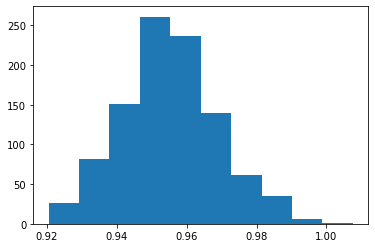

In [108]:
plt.hist(optimal_price)

(array([ 14.,  23.,  70., 177., 229., 250., 154.,  59.,  17.,   7.]),
 array([445.75362963, 463.79566436, 481.83769908, 499.8797338 ,
        517.92176852, 535.96380324, 554.00583796, 572.04787268,
        590.08990741, 608.13194213, 626.17397685]),
 <BarContainer object of 10 artists>)

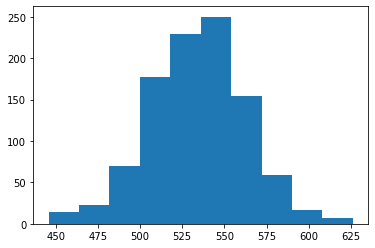

In [109]:
plt.hist(optimal_quantity)

In [110]:
import seaborn as sns

C:\Users\prakh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


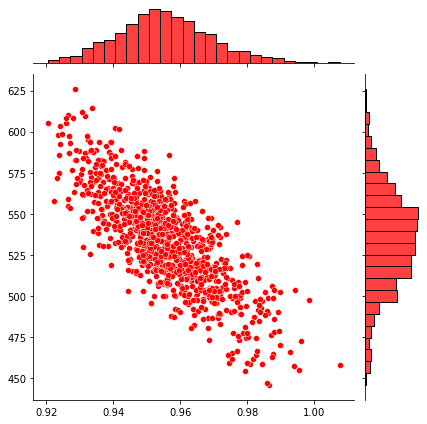

In [117]:
sns.jointplot(optimal_price,optimal_quantity,color='red',kind='scatter')